In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
import numpy as np
import psutil
import os
import seaborn as sns
import sys
import matplotlib.pyplot as plt
# local imports
from runs import run


# add src directory to path
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(os.path.join(ROOT_DIR, 'src'))

sns.set(style="whitegrid", context="talk", font_scale=1.2, palette=sns.color_palette("bright"), color_codes=False)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'DejaVu Sans'
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['figure.figsize'] = (9, 6)

## Parameters

In [3]:
psutil.cpu_count(logical=True)

24

In [4]:
from objectives import ObjMSE, ObjRidge
from runs import PSMomentum, PSDefault

iterations = 500
num_workers = 10
it_check = 40
seed=42
batch_size = 16
dim = 5
# PSClass = PSMomentum
PSClass = PSDefault

objective = ObjMSE(seed=0, dim=dim, n_data=5000)
# objective = ObjRidge(seed=0, dim=dim, n_data=5000, reg_coef=1e-4)


## Synchronous

In [5]:
lr_mini = 0.19 # best tuned
lr_decay = 0
its_, ts_, losses_, _ = run(objective, seed, num_workers, lr=lr_mini, lr_decay=lr_decay, iterations=iterations, 
                            asynchronous=False, delay_adaptive=False, it_check=it_check, batch_size=batch_size, one_bad_worker=False, PSClass=PSClass)

2023-06-11 17:35:29,336	INFO worker.py:1627 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8266 


In [6]:
lr_as = 0.2 #0.33 # best tuned
lr_decay = 0
its_as, ts_as, losses_as, _ = run(objective, seed, num_workers, lr=lr_as, lr_decay=lr_decay, 
                                  iterations=iterations, asynchronous=True, delay_adaptive=False, 
                                  it_check=it_check, batch_size=batch_size, one_bad_worker=False, PSClass=PSClass)

2023-06-11 17:35:39,185	INFO worker.py:1627 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8266 


In [7]:
lr_ad = 0.2 #0.43 # best tuned
lr_decay = 0
its_ad, ts_ad, losses_ad, delays = run(objective, seed, num_workers, lr=lr_ad, lr_decay=lr_decay, 
                                       iterations=iterations, asynchronous=True, delay_adaptive=True, 
                                       it_check=it_check, batch_size=batch_size, one_bad_worker=False, PSClass=PSClass)

2023-06-11 17:35:49,874	INFO worker.py:1627 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8266 


Text(0, 0.5, '$F(\\mathbf{x}) - F^*$')

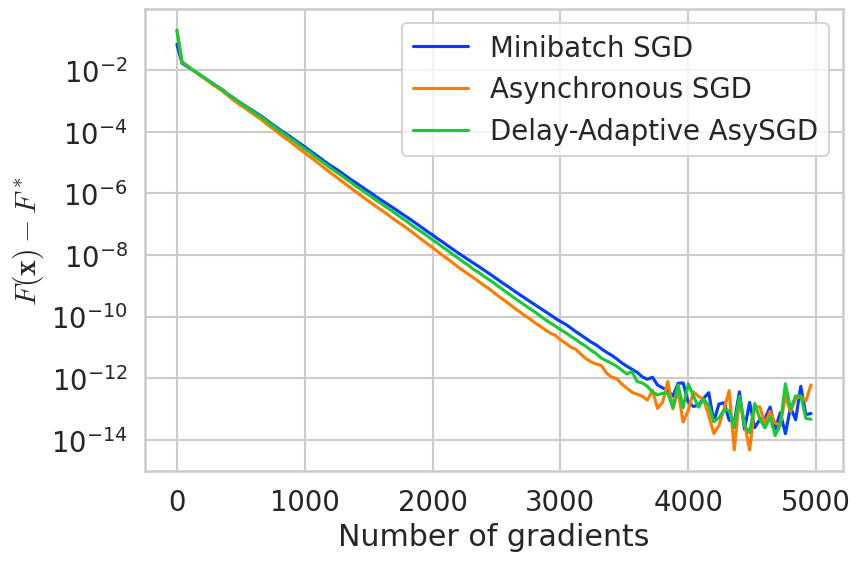

In [8]:
f_min = objective.f_min

plt.plot(its_ * num_workers, losses_ - f_min, label='Minibatch SGD')
plt.plot(its_as, losses_as - f_min, label='Asynchronous SGD')
plt.plot(its_ad, losses_ad - f_min, label='Delay-Adaptive AsySGD')
plt.yscale('log')
plt.legend()
plt.xlabel('Number of gradients')
plt.ylabel(r'$F(\mathbf{x}) - F^*$')
# plt.savefig(f'quadratic_grads_M_{num_workers}_n={n_data}_dim={dim}_bs_{batch_size}.pdf', bbox_inches='tight')

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


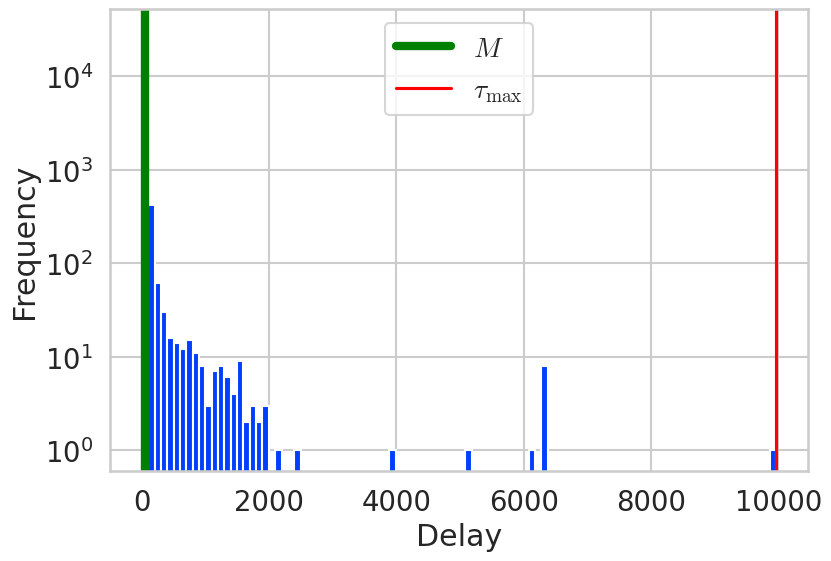

In [19]:
plt.hist(delays, bins=100)
plt.axvline(num_workers, color='green', label=r'$M$', linewidth=6)
plt.axvline(np.max(delays), color='red', label=r'$\tau_{\max}$')
plt.xlabel('Delay')
plt.ylabel('Frequency')
plt.yscale('log')
plt.legend()
plt.savefig(f'quadratic_delays_M_{num_workers}_n={objective.N}_dim={objective.D}_bs={batch_size}.pdf', bbox_inches='tight')